# Data Exploration and Cleaning

As the dataset is large and we're running on a tight budget, the first step is to analyse the data. Our goal is to find relevant artists, get an overview for the distribution of songs relative to distinct artits and gaining new insights. Furthermore it's imortant to clean the lyrics and remove all non-relevant artifacts, as headlines or adlibs.

### Contents
- Exploration
- Cleaning

In [392]:
import os # needed?
import numpy as np # needed?
import matplotlib.pyplot as plt
import pandas as pd

import re
import time as time

## Exploration
### Data Loading

As the dataset is initially rather larger (9GB), we'll divide it up into chunks, thus reducing workload.
We're only interested in german rap, so we'll be dropping all rows which fail on these conditions.

In [14]:
# A first quick test...
for chunk in pd.read_csv('song_lyrics.csv', chunksize=1000):
    for index, row in chunk.iterrows():
        print(row)
        break
    break

title                                                    Killa Cam
tag                                                            rap
artist                                                     Cam'ron
year                                                          2004
views                                                       173166
features                               {"Cam\\'ron","Opera Steve"}
lyrics           [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...
id                                                               1
language_cld3                                                   en
language_ft                                                     en
language                                                        en
Name: 0, dtype: object


In [ ]:
chunk_count = 0
header = True
start = time.time()

for chunk in pd.read_csv('song_lyrics.csv', chunksize=100000):
    chunk.drop(chunk[(chunk.tag != 'rap') | (chunk.language!='de')].index, axis=0, inplace=True)

    if not chunk.empty:
        # We're only interested it some columns, ignoring the rest.
        chunk.to_csv('raps_de.csv', header=header,index=False, columns=['title','artist', 'year','views','lyrics', 'language'], mode='a')
        header = False
        print('Chunk {} contained german rap!'.format(chunk_count))
        
    chunk_count += 1

end = time.time()
print("Went through a total of {} chunks".format(chunk_count))
print("This took {} seconds".format(int(end-start)))

From now on, we'll be working with just german rap songs.

In [308]:
raps_de =  pd.read_csv('raps_de.csv')
raps_de.head()

,title,artist,year,views,lyrics,language
0,Keine Zeit,Blumentopf,2006,112,"Roger:\nIch stell mich diesmal nicht an! Ne, N...",de
1,8073,Austria's Finest,2010,416,Austrias FinesT - 8073\n\nVerse I:\n8073 (Boom...,de
2,Ego,Samy Deluxe,2011,15472,"[Intro]\nYeah, Dynamite, Johnny\nMachen die Sc...",de
3,Stenz Music,Eko Fresh,2005,881,"[Verse I: Hakan Abi]\nDas ist Hakan Abi, ich l...",de
4,Strassen Musik,Samy Deluxe,2011,3958,"[Intro]\nOh, late at night when I was asleep\n...",de


We'll be manipulating the data, dropping rows and cleaning lyrics, as such it's good to keep an overview how some properties of the data change.

Following function will be helpfull for this purpose.

In [391]:
def data_props(df):

    number_of_rows = 0
    total_song_length = 0
    for idx, row in df.iterrows():
        number_of_rows += 1
        total_song_length += len(row.lyrics)

    avg_len = int(total_song_length/number_of_rows)
    print("Total number of rows: ", number_of_rows)
    print("Average length of rap: ", avg_len)

    # one token is aprox. 4 chars so:
    number_of_tokens = int(total_song_length/4)
    print(number_of_tokens/1000, "K tokens")
    print("With 0.002/1K tokens if we take gpt-3.5-turbo model that makes ", int(number_of_tokens/1000*0.002), " dollars")

data_props(raps_de)

Total number of rows:  36264
Average length of rap:  2218
20111.246 K tokens
With 0.002/1K tokens if we take gpt-3.5-turbo model that makes  40  dollars


Lets take a first look into the distribution of songs and artists.

In [ ]:
for idx, row in raps_de['artist'].value_counts().items():
    print(idx,row)

In [309]:
# Dont care about english songs with german translations...
# Drop Übersetzungen
raps_de.drop(raps_de[raps_de['artist']=='Genius Deutsche bersetzungen'].index, inplace=True)
raps_de['artist'].value_counts()

Money Boy                  652
Kollegah                   538
Eko Fresh                  488
Fler                       429
Bushido                    405
                          ... 
MC Alkatraz                  1
Fisto                        1
To?                          1
Sido & Johannes Oerding      1
Endi & Ilias                 1
Name: artist, Length: 13863, dtype: int64

It's actually really surprising that Money Boy has the highest output. Quick sanity check if everything is ok...

In [195]:
raps_de[raps_de['artist']=='Money Boy']['title'].value_counts()

Dreh den Swag auf              1
Intro Swagger Rap              1
Try me                         1
We Made It Remix               1
Die Trap Ist Am Durchdrehen    1
                              ..
Shots Fired                    1
Elevator                       1
Körperbau Utopisch             1
Ein Stück vom Kuchen           1
Churros                        1
Name: title, Length: 652, dtype: int64

Seems so! As it would be indeed interesting to look at artists with such a high output seperatly, we're interested in the broad landscape of german rap. This means we don't need all of the songs. Also our budget constraints how many tokens we can use, so we have the reduce the size of our dataset.

In [341]:
# We dont need more than N songs per artist

N = 20

for artist, song_n in raps_de['artist'].value_counts().items():
    #print(artist)
    if song_n > N:
        sample_size = song_n-N
        # Randomly drop songs for thespecific artist until we reach the desired amount of songs.
        # It would ofcourse be nice to choose one song of each album, sadly we dont have this information, so random it is.
        raps_de.drop(raps_de[raps_de['artist'] == artist].sample(sample_size, random_state=42).index, inplace=True)


In [311]:
# We again look at the tokens of the new dataset:
data_props(raps_de)

Total number of rows:  71132
Average length of rap:  2307
41025.516 K tokens
With 0.0005/1K tokens if we take babbage model that makes  20  dollars


We're not down much, to my surprise there seems to be alot of artists who only have few songs listed on Genius. Let's look into this...

In [317]:
def count_artists_and_songs(df, N, verbose=True):

    n_songs_artist_under = 0
    n_artists_under = 0
    n_songs_artist_above = 0
    n_artists_above = 0

    for artist, song_n in df['artist'].value_counts().items():
        if song_n < N:
            n_artists_under += 1
            n_songs_artist_under += song_n
        else:
            n_artists_above += 1
            n_songs_artist_above += song_n
            #print(artist)

    if verbose:
        print(n_artists_under, " artists made under {} songs".format(N))
        print("The average number of tokens we get for artists with under {} songs are {}K tokens ".format(N, int(n_songs_artist_under*avg_len/4000)))
        print(n_artists_above, " artists made over or equal to {} songs".format(N))
        print("The average number of tokens we get for artists with above {} songs are {}K tokens".format(N, int(n_songs_artist_above*avg_len/4000)))
        if n_artists_above != 0:
            print("There are {} times more artists with under {} songs".format(int(n_artists_under/n_artists_above), N))
            print("And they account for {} times more tokens".format(int(n_songs_artist_under/n_songs_artist_above)))
        else:
            print("Obviously no artist has less than one song")
    
    return {"Number of songs of artists under" :n_songs_artist_under, "Number of artists under": n_artists_under, 
            "Number of songs of artists above" :n_songs_artist_above, "Number of artists above": n_artists_above}

count_artists_and_songs(raps_de, 20)

4489  artists made under 20 songs
The average number of tokens we get for artists with under 20 songs are 10252K tokens 
941  artists made over or equal to 20 songs
The average number of tokens we get for artists with above 20 songs are 20855K tokens
There are 4 times more artists with under 20 songs
And they account for 0 times more tokens


{'Number of songs of artists under': 17444,
 'Number of artists under': 4489,
 'Number of songs of artists above': 35485,
 'Number of artists above': 941}

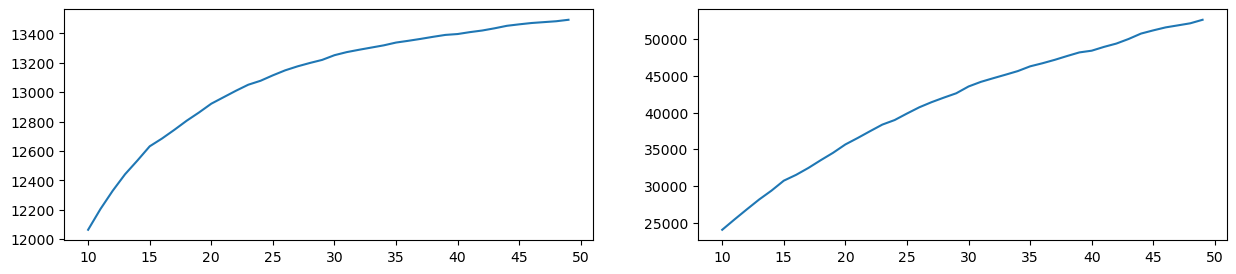

In [256]:
res_artists = {}
res_songs = {}

for i in range(10,50):
    res = count_artists_and_songs(i, verbose=False)
    res_artists[i] = res["Number of artists under"]
    res_songs[i] = res["Number of songs of artists under"]
    #res_songs[i] = int(res["Number of songs of artists under"]*avg_len/4000) # This is then per 1K tokens!

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(res_artists.keys(), res_artists.values())#, tick_label=list(res_artists.keys()))
axes[1].plot(res_songs.keys(), res_songs.values())#, tick_label=list(res_songs.keys()))
plt.show()

In [700]:
artist_songs_count = raps_de.artist.value_counts().to_dict()
# dict of: number of songs: list of artists with that number of songs
song_n_artist_list = {i: [artist for artist, val in artist_songs_count.items() if val==i] for i in artist_songs_count.values()}
for song_n, artist_list in song_n_artist_list.items():
    print("{} artists have {} songs".format(len(artist_list), song_n))


941 artists have 20 songs
60 artists have 19 songs
56 artists have 18 songs
62 artists have 17 songs
59 artists have 16 songs
53 artists have 15 songs
97 artists have 14 songs
93 artists have 13 songs
112 artists have 12 songs
125 artists have 11 songs
55 artists have 10 songs
47 artists have 9 songs
45 artists have 8 songs
63 artists have 7 songs
94 artists have 6 songs
86 artists have 5 songs
124 artists have 4 songs
169 artists have 3 songs
357 artists have 2 songs
2732 artists have 1 songs


In [271]:
song_n_total_len = {song_n: 0 for song_n in song_n_artist_list.keys()}
"""
for song_n, number_of_songs in res_songs.items():
    for artist in song_n_artist_list[song_n]:
        song_n_total_len[song_n] += raps_de.at
    break"""
    #ToDo: for every artists in range 10,51: add length of songs, divide by number of artists with that song number, 
    # in order to get average length of songs relative to number of songs released.
for idx, row in raps_de.iterrows():
    for song_n, artist_list in song_n_artist_list.items():
        if row.artist in artist_list:
            song_n_total_len[song_n] += len(row.lyrics)

In [272]:
song_n_total_len

{50: 42419649,
 49: 1771933,
 48: 1125540,
 47: 693873,
 46: 603161,
 45: 985203,
 44: 977288,
 43: 1695286,
 42: 1546771,
 41: 1071683,
 40: 1202037,
 39: 544983,
 38: 1068583,
 37: 1294628,
 36: 1056586,
 35: 1035444,
 34: 1553801,
 33: 1197080,
 32: 1065572,
 31: 1078671,
 30: 1463799,
 29: 2114758,
 28: 1504501,
 27: 1420412,
 26: 1743876,
 25: 1985702,
 24: 1979424,
 23: 1459013,
 22: 2078725,
 21: 2180952,
 20: 2031147,
 19: 2598163,
 18: 2474202,
 17: 2534015,
 16: 2359562,
 15: 1945002,
 14: 3076728,
 13: 2933650,
 12: 2994289,
 11: 2992467,
 10: 3159190,
 9: 2853744,
 8: 3277468,
 7: 3638636,
 6: 4300263,
 5: 4176883,
 4: 4513947,
 3: 5501215,
 2: 7525359,
 1: 17297203}

In [286]:
song_n_avg_len = {}

for song_n, total_len in song_n_total_len.items():
    song_n_avg_len[song_n] = int(total_len/(song_n*len(song_n_artist_list[song_n])))
song_n_avg_len

{50: 2389,
 49: 2410,
 48: 2344,
 47: 2460,
 46: 2185,
 45: 2432,
 44: 2221,
 43: 2319,
 42: 2455,
 41: 2376,
 40: 2311,
 39: 2328,
 38: 2163,
 37: 2499,
 36: 2257,
 35: 2465,
 34: 2405,
 33: 2418,
 32: 2219,
 31: 2174,
 30: 2323,
 29: 2278,
 28: 2558,
 27: 2287,
 26: 2484,
 25: 2336,
 24: 2229,
 23: 2349,
 22: 2304,
 21: 2360,
 20: 2308,
 19: 2279,
 18: 2454,
 17: 2404,
 16: 2499,
 15: 2446,
 14: 2265,
 13: 2426,
 12: 2227,
 11: 2176,
 10: 2240,
 9: 2201,
 8: 2226,
 7: 2174,
 6: 2198,
 5: 2131,
 4: 2199,
 3: 2241,
 2: 2214,
 1: 2232}

As we see, regardless of song output, song length is on average the same.

Let's look into colaborations of artists, which are named with the convention: "Artist A & Artist B"

In [312]:
n_of_colabs = 0
list_of_colabs = []
for artist, song_n in raps_de.artist.value_counts().items():
    if '&' in artist:
        n_of_colabs += 1
        list_of_colabs.append(artist)
        #print(artist, song_n)
        
print("Number of colabs: ", n_of_colabs)

Number of colabs:  3343


In [289]:
# We need the artists by itself, without the colab naming convention:
complete_colabs = []
for colabs in list_of_colabs:
    complete_colabs.append(colabs.split(' & '))
complete_colabs = [item for sublist in complete_colabs for item in sublist]

In [175]:
artists_song_number_dict = raps_de.artist.value_counts().to_dict() # didn't we do this already above? CONST would be nice

['abc']

In [321]:
# Or we could drop all below 10 songs unless they appear as features
n_artists_under_10_no_colabs = 0

# colabs are not longer in complete_colabs, because of naming "abc & xyz" !!!
for artists, song_n in artists_song_number_dict.items():
    for artist in artists.split(' & '):
        if song_n <= 10 and artist not in complete_colabs:
            n_artists_under_10_no_colabs += 1
            raps_de.drop(raps_de[raps_de.artist==artist].index, inplace=True)
    
print(n_artists_under_10_no_colabs)




8433


In [314]:
data_props(raps_de) # with 50 songs max


Total number of rows:  52929
Average length of rap:  2363
31279.852 K tokens
With 0.0005/1K tokens if we take babbage model that makes  15  dollars


In [342]:
data_props(raps_de) # with 20 songs max (delete again later)

Total number of rows:  36264
Average length of rap:  2362
21417.178 K tokens
With 0.0005/1K tokens if we take babbage model that makes  10  dollars


In [315]:
count_artists_and_songs(raps_de, 10) # with 50 songs max

3717  artists made under 10 songs
The average number of tokens we get for artists with under 10 songs are 3918K tokens 
1713  artists made over or equal to 10 songs
The average number of tokens we get for artists with above 10 songs are 27188K tokens
There are 2 times more artists with under 10 songs
And they account for 0 times more tokens


{'Number of songs of artists under': 6667,
 'Number of artists under': 3717,
 'Number of songs of artists above': 46262,
 'Number of artists above': 1713}

In [345]:
count_artists_and_songs(raps_de, 13) # with 20 songs max (delete again later)

4009  artists made under 13 songs
The average number of tokens we get for artists with under 13 songs are 5839K tokens 
1421  artists made over or equal to 13 songs
The average number of tokens we get for artists with above 13 songs are 15473K tokens
There are 2 times more artists with under 13 songs
And they account for 0 times more tokens


{'Number of songs of artists under': 9936,
 'Number of artists under': 4009,
 'Number of songs of artists above': 26328,
 'Number of artists above': 1421}

In [331]:
raps_de_min_4_songs = raps_de.copy()
for artists, song_n in artists_song_number_dict.items():
        if song_n <= 10:
            raps_de_min_4_songs.drop(raps_de_min_4_songs[raps_de_min_4_songs.artist==artists].index, inplace=True)


In [332]:
data_props(raps_de_min_4_songs)

Total number of rows:  45712
Average length of rap:  2359
26964.539 K tokens
With 0.0005/1K tokens if we take babbage model that makes  13  dollars


In [335]:

count_artists_and_songs(raps_de_min_4_songs, 15)

427  artists made under 15 songs
The average number of tokens we get for artists with under 15 songs are 3106K tokens 
1231  artists made over or equal to 15 songs
The average number of tokens we get for artists with above 15 songs are 23758K tokens
There are 0 times more artists with under 15 songs
And they account for 0 times more tokens


{'Number of songs of artists under': 5286,
 'Number of artists under': 427,
 'Number of songs of artists above': 40426,
 'Number of artists above': 1231}

## Cleaning the Lyrics

In [354]:
# Cleaning the lyrics
import re
import time

start = time.time()
for idx, row in raps_de.iterrows():
    raps_de.at[idx, 'lyrics'] = re.sub("[\(\[].*?[\)\]]", "", row.lyrics)
    #print(row.lyrics)
    #break
    
end = time.time()
end-start

3.0730931758880615

In [355]:
raps_de.head()

,title,artist,year,views,lyrics,language
17,All 4 One,Kool Savas & Azad,2005,24969,"\nEs ist Zeit, dass sich einiges ändert hier\n...",de
34,Herbstzeitblätter,K.I.Z,2007,20716,\nSind Herbstzeitblätter nur so traurig weil s...,de
35,Neuruppin,K.I.Z,2007,127191,\nSpinnenmann!\nIch creepe durch die Nachbarsc...,de
51,Danke Gut,Eins Zwo,1999,7688,Ja gut\n'N abend zusammen!\n\n\nEs geht mir gu...,de
77,Hammerhart,Beginner,1998,20823,"\nOh, na, na\nBambule - Yes, yo\nDies ist Hamb...",de


In [701]:
# We again look at the tokens of the new dataset:
data_props(raps_de)

Total number of rows:  36264
Average length of rap:  2218
20111.246 K tokens
With 0.002/1K tokens if we take gpt-3.5-turbo model that makes  40  dollars


### Reducing Size and finding relevant Artists

So, it seems we need to "handpick" a set of artists in order to effectively reduce our dataset size and feed it into gpt.

I played around a little bit and tried cutting down the dataset to a size around 5-8 dollars. But, doing that on my own would probably result in a biased dataset, which I do not want. So I choose to take another route, grabbing a list of artists from spotify! We use the spotipy api, but notice that the spotify api is a little clunky and only returns 50-100 artists at a time. We'll be looping through the last 20 years and see how many artists we actually get. Thencheck how many of them are in our dataset and hopefully we receive a size that's representative, but small enough to walk with.

## Getting the list from Spotify

In [705]:
with open('spotify_secrets.txt', 'r') as f:
    text = f.readlines()
    SPOTIPY_CLIENT_ID = text[0].strip('\n')
    SPOTIPY_CLIENT_SECRET = text[1].strip('\n')

#print(SPOTIPY_CLIENT_ID)
#print(SPOTIPY_CLIENT_SECRET)

In [480]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [622]:
# testing spotipy

birdy_uri = 'spotify:artist:2WX2uTcsvV5OnS0inACecP'
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET))

results = spotify.search(q='2000-2010%20genre:Deutschrap', limit=50, type='artist', market='DE', offset=100)
print(results['artists']['href'])
print(results['artists']['total'])
print(results['artists']['offset'])
print(len(results['artists']['items']))
print(results['artists']['items'][0])

https://api.spotify.com/v1/search?query=2000-2010%2520genre%3ADeutschrap&type=artist&market=DE&offset=100&limit=50
1000
100
0


IndexError: list index out of range

In [663]:
test_list_aaa = []

In [662]:
start = 1989
for i in range(17):
    
    end = start+2
    print(start, "-", end)
    start = end

1989 - 1991
1991 - 1993
1993 - 1995
1995 - 1997
1997 - 1999
1999 - 2001
2001 - 2003
2003 - 2005
2005 - 2007
2007 - 2009
2009 - 2011
2011 - 2013
2013 - 2015
2015 - 2017
2017 - 2019
2019 - 2021
2021 - 2023


In [ ]:

start = 1989
for i in range(17):
    
    end = start+2
    print(start, "-", end)
    
    for i in range(0, 200, 50):
        results = spotify.search(q=str(start)+'-'+str(end)+'%20genre:Deutschrap',limit=50, type='artist', market='DE', offset=i)
        print("offset=", i)
        print(results['artists']['href'])
        for item in results['artists']['items']:
            print(item['popularity'], end=' ')
            #if item['popularity'] > 50:
            print(item['name'], item['popularity'])
            test_list_aaa.append(item['name'])
    start = end

In [668]:
print(len(test_list_aaa))
set_of_artists = set(test_list_aaa)
print(len(set_of_artists))

3400
357


In [681]:
is_in_count = 0
for it in set_of_artists:
    if it in raps_de.artist.value_counts().keys():
        is_in_count += 1
print("Of {} artists there are {} in our dataset".format(len(set_of_artists), is_in_count))

Of 357 artists there are 213 in our dataset


In [682]:
final_artists = []
for it in set_of_artists:
    if it in raps_de.artist.value_counts().keys():
        final_artists.append(it)
print(len(final_artists))

213


In [683]:
second_raps_de = raps_de.copy()

In [684]:
for artists, song_n in second_raps_de['artist'].value_counts().items():
    if not artists in final_artists:
        second_raps_de.drop(second_raps_de[second_raps_de.artist==artists].index, inplace=True)

In [710]:
second_raps_de['artist'].value_counts()

Beginner       20
negatiiv OG    20
JAZN           20
GENT           20
Curse          20
               ..
Rill            2
Addikt102       2
ELIF            2
DXVE            1
Maikel          1
Name: artist, Length: 213, dtype: int64

In [686]:
data_props(second_raps_de)

Total number of rows:  3641
Average length of rap:  2212
2014.046 K tokens
With 0.002/1K tokens if we take gpt-3.5-turbo model that makes  4  dollars


In [694]:
count_artists_and_songs(second_raps_de, 20)

59  artists made under 20 songs
The average number of tokens we get for artists with under 20 songs are 329K tokens 
154  artists made over or equal to 20 songs
The average number of tokens we get for artists with above 20 songs are 1810K tokens
There are 0 times more artists with under 20 songs
And they account for 0 times more tokens


{'Number of songs of artists under': 561,
 'Number of artists under': 59,
 'Number of songs of artists above': 3080,
 'Number of artists above': 154}

In [696]:
second_raps_de.to_csv('second_raps_de.csv', index=False)

In [698]:
test_aba = pd.read_csv('second_raps_de.csv')
test_aba

,title,artist,year,views,lyrics,language
0,Hammerhart,Beginner,1998,20823,"\nOh, na, na\nBambule - Yes, yo\nDies ist Hamb...",de
1,Und Was Ist Jetzt?,Curse,2003,9420,\nIch hör' dich jetzt noch wie gestern die Wor...,de
2,Zur Erinnerung,Ferris MC,2003,4701,"\nWir lernten uns beide kennen, als wir ins gl...",de
3,Popstarz,Ferris MC,2003,474,Kurzes Intro:\n\nYeah Ferris MC und ich hasse ...,de
4,Pyramide,Favorite,2011,8648,"\nYeah, yeah, yeah, was geht ab?!\nFavorite 20...",de
...,...,...,...,...,...,...
3636,Habaneros,TIEFBASSKOMMANDO,2022,10,"\nIch hab' ein Colt in meiner Hose, der ist sc...",de
3637,Ein Fall für sich,Manuellsen,2022,87,"\n\n\nLak, shu, diese Zeil'n!\n\n\nIch bin ein...",de
3638,Northern Lights,Samo104,2022,7,"\n\n\n\n\n\nAll eyes on her, ja \nLiebe dein S...",de
3639,Kein Auge zu,Samo104,2022,32,\n\n\nIch mach' schon wieder kein Auge zu\nWei...,de


Finally, we've shrunken our dataset down to a reasonable size, containing all the biggest (and also some quite underground) german rappers! Expected cost of putting this data into gpt-3.5-turbo: 4 dollar! Thats great, as it offers us some room for errors while working with the models.